In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


In [51]:
random_state=123
best_models = {}

In [52]:
# Read in the data
df = pd.read_csv('../Data/Final_skin_cancer.csv')

df.drop('drink', axis=1, inplace=True)


df

,smoke,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,diagnostic
0,False,55,False,0,True,True,True,True,1
1,False,79,False,1,True,False,False,False,1
2,False,52,False,0,False,True,True,True,1
3,False,74,True,0,False,False,False,False,1
4,False,58,True,0,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...
1700,False,23,True,0,False,True,True,True,0
1701,False,27,False,0,False,False,True,True,0
1702,True,23,False,1,False,False,True,True,0
1703,False,23,True,0,False,False,True,False,0


In [53]:
df.isnull().sum()

smoke                  0
age                    0
pesticide              0
gender                 0
skin_cancer_history    0
cancer_history         0
has_piped_water        0
has_sewage_system      0
diagnostic             0
dtype: int64

# New Section

In [54]:
from sklearn.model_selection import train_test_split

def splitting_data(df, sampling, test_size=0.2, random_state=123):
    # First, split the data into features and target variable
    X = df.drop(['diagnostic'], axis=1)
    y = df['diagnostic']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply sampling methods to the training data based on the specified method
    if sampling == 'none':
        return X_train, X_test, y_train, y_test
    elif sampling == 'SMOTEENN':
        from imblearn.combine import SMOTEENN
        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'SMOTE':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'under':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'over':
        from imblearn.over_sampling import RandomOverSampler
        rus = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test

In [55]:

def training(X_train, y_train):
    # Create a KNN classifier with 5 neighbors
    LGBM = AdaBoostClassifier()
    # Fit the classifier to the data
    LGBM.fit(X_train, y_train)
    return LGBM

In [56]:
def best_model(modelName, accuracy, precision, recall, f1):
    best_models[modelName] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [57]:
def predict(modleName,LGBM, X_test ,y_test):
    # Predict the labels for the training data X
    y_pred = LGBM.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr=classification_report(y_test, y_pred, output_dict=True)
    precision = cr['weighted avg']['precision']
    recall = cr['weighted avg']['recall']
    f1 = cr['weighted avg']['f1-score']
    best_model(modleName,accuracy,precision,recall,f1)
    cr=classification_report(y_test, y_pred)
    print(cr)

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def optimize_with_grid(X_train, y_train, random_state=None):
    # Define a pipeline that first scales the data and then applies the classifier
    pipe = Pipeline([
        # ('scaler', StandardScaler()),
        ('adaboost', )
    ])

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [50, 100, 200],  # Number of base estimators to use
        'learning_rate': [0.01, 0.1, 1],  # Learning rate shrinks the contribution of each classifier
    }

    # Create the GridSearchCV object
    adaboost_cv = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state), param_grid, cv=5, verbose=1, n_jobs=-1)

    # Perform the grid search on the provided data
    adaboost_cv.fit(X_train, y_train)

    # Best parameters and best score
    best_params = adaboost_cv.best_params_
    best_score = adaboost_cv.best_score_
    best_estimator = adaboost_cv.best_estimator_
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_estimator

# Example usage (ensure you have defined X_train, y_train, and random_state before calling this function)
# best_adaboost_model = optimize_with_grid(X_train, y_train, random_state=42)


<h1> LGBM on original data with optimization </h1>

In [59]:
# using function with no sampling
X_train, X_test, y_train, y_test = splitting_data(df, 'none')
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
#check number of observations in each class in the set
print("Number of observations in each class in the training set:")
print(y_train.value_counts())

Number of observations in each class in the training set:
diagnostic
1    1192
0     172
Name: count, dtype: int64


In [61]:
LGBM1 = training(X_train, y_train)
y_pred = predict('original',LGBM1, X_test, y_test)


              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.96      0.98      0.97       302

    accuracy                           0.95       341
   macro avg       0.91      0.85      0.88       341
weighted avg       0.95      0.95      0.95       341



/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [62]:
best_LGBM1 = optimize_with_grid(X_train, y_train)
prediction = predict('original_grid',best_LGBM1, X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Best Score: 0.9369640163757811
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        39
           1       0.98      0.98      0.98       302

    accuracy                           0.96       341
   macro avg       0.90      0.91      0.91       341
weighted avg       0.96      0.96      0.96       341



/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


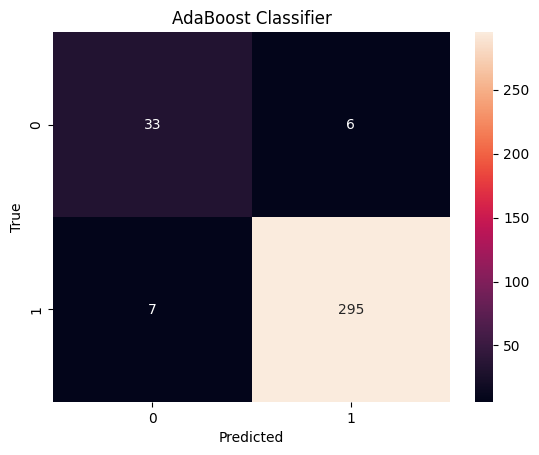

In [63]:
# plot the confusion matrix for the model
y_pred = best_LGBM1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('AdaBoost Classifier')
plt.show()


In [64]:
best_model_df = pd.DataFrame.from_dict(best_models, orient='index')
best_model_df.sort_values(by='accuracy', ascending=False, inplace=True)
best_model_df
# 0.992248
# 0.996139

,accuracy,precision,recall,f1
original_grid,0.961877,0.962332,0.961877,0.962087
original,0.953079,0.951042,0.953079,0.951355
